# Core-CT Visualization Demo

This Jupyter Notebook demonstrates how the `core-ct` library can be used, focusing on tools to visualize the core.
In this notebook, we will go over an example workflow for visualizing and analyzing a core CT scan, including:
* Creating a `Core` from dicom files
* Displaying various views of the core
* Trimming unwanted space from the `Core` object
* Taking a single slice from a core
* Creating a brightness trace plot from a core slice

## Setup
### 1. Import Necessary Libraries

In [1]:
import os
import matplotlib.pyplot as plt
from core_ct import importers
from core_ct import visualize

### 2. Set Behavior of Matplotlib
The `IPython` kernel allows us to use magic commands to customize the behavior of our notebook. We will use a magic command to control the behavior of `matplotlib`.  

* To create non-interactive plots that appear inside the notebook, use `%matplotlib inline`. This is the default behavior, so you do not need to state it explicitly.
* To create interactive plots that open in a new window, use `%matplotlib`. You may need to write this command twice to get the desired behavior.
* To create interactive plots that appear inside the notebook, use `%matplotlib widget`. This may cause more lag when interacting with the plots than opening it in a separate window.

You can also add magic commands throughout the notebook if you want different behaviors for different plots. Note that you cannot change the GUI backend mid-notebook, but you can change between `inline` and interactive. A full list of matplotlib magic options can be found [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib).

In [2]:
# Choose your desired plotting behavior by commenting/uncommenting lines in this cell

# %matplotlib inline

%matplotlib widget

# %matplotlib 
# %matplotlib

## Load the Core Data
For this demo, we will be using sediment core CT scan data from the 2023 paper "The life and death of a subglacial lake in West Antarctica." by [Siegfried, Venturelli et al.](https://pubs.geoscienceworld.org/gsa/geology/article/51/5/434/620903/The-life-and-death-of-a-subglacial-lake-in-West) [[1]](#References).  

Download and unzip the file `data.zip` from Zenodo, which you can find [here](https://zenodo.org/records/7597019). (Uncompressed size ~32 GB) [[2]](#References).
The data we will use is under `data/cores/01UW-C`. Load this using `dicom` from the `importers` module. 

In [3]:
dir_path = os.path.join("data", "cores", "01UW-C")
# the force option ignores files that produce errors (non-DICOMs)
my_core = importers.dicom(dir = dir_path, force = True)

## Displaying the Core
Before we do any processing of the core, we want to get some information about it, including:
* the dimensions of the 3D `pixel_array` representing the entire core
* how the core is oriented, that is, how the axes of the core scan correspond to the axes of the `pixel_array`.

The shape of the core is:  (1560, 1560, 34)


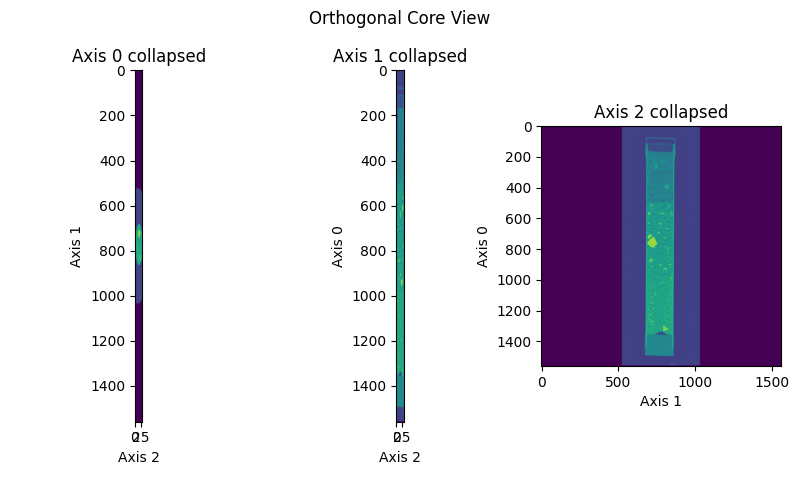

In [4]:
# TODO update shape after more PRs are merged
print("The shape of the core is: ", my_core.pixel_array.shape) 

# display orthogonal views of the core sliced along each axis
fig, (ax1, ax2, ax3) = visualize.display_core(my_core)
fig.set_figwidth(8)
plt.show()

From this visualization, we can see that axis 0 is the long axis of the core (down the page), axis 1 goes across the page, and axis 2 goes into the page. We also see that clearly we want to collapse along axis 2 to get a nice cross-section of the entire core. This will become the axis we will pass to the `slice` method.

## Trimming the Core
We know we want to slice at a location along axis 2, but aren't sure exactly where we want to trim the core. We can visualize possible trim lines on the core using `visualize_trim`.

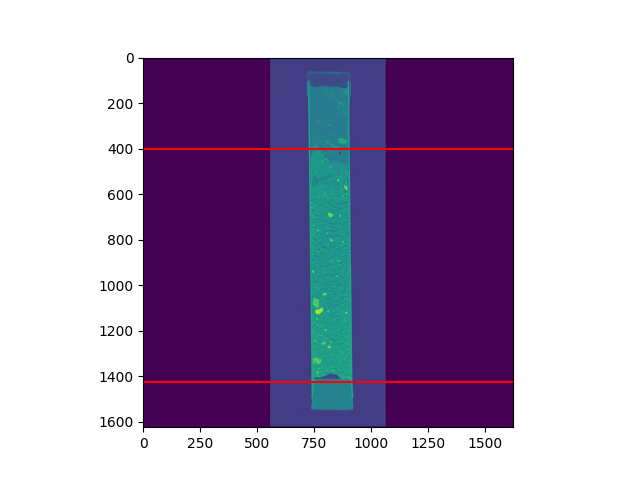

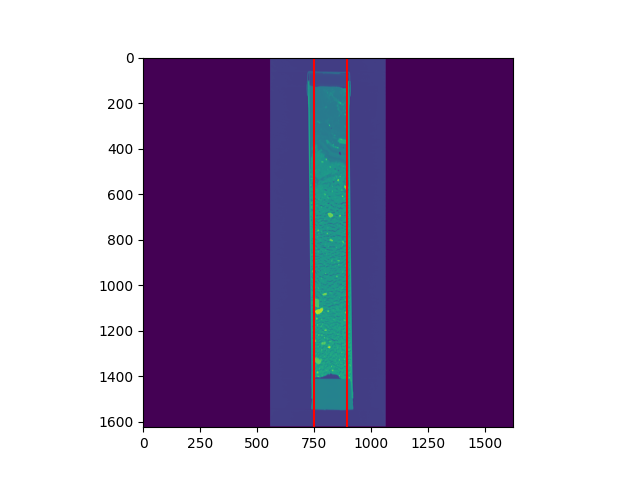

In [5]:
core_slice = my_core.slice(axis = 2, loc = my_core.pixel_array.shape[2]//2)
visualize.visualize_trim(slice_2d = core_slice, axis = 1, loc_start = 750, loc_end = 730)
visualize.visualize_trim(slice_2d = core_slice, axis = 0, loc_start = 400, loc_end = 200)
plt.show()

In [10]:
# Now we will actually trim the core. From the orthogonal view we want to choose axis 1, and from the trim viz we 
# know what indices we want
my_core.trim(axis = 1, loc_start = 750, loc_end = 730)

my_core.trim(axis=0, loc_start = 400, loc_end = 200) # is symmetric 

# we can verify the trim worked
core_dim = my_core.pixel_array.shape
print(core_dim)

# and display the new trimmed core
fig, (ax1, ax2, ax3) = visualize.display_core(my_core)

(1024, 144, 32)


In [13]:
# now we want to take a slice, collapsing axis 2 as per our visualization above
axis = 2
slice_loc = int(core_dim[axis]/2) # right in the middle
my_slice = my_core.slice(axis=axis, loc=slice_loc)
visualize.display_slice(my_slice)
plt.show()

In [12]:
# now we want to display the core next to the brightness trace and standard deviation brightness
fig, (ax1, ax2, ax3) = visualize.display_slice_bt_std(my_slice)
# you can change different plot elements, such as axis labels, figure titles, or figure shape
# fig.suptitle("Sediment Core Brightness Trace")
fig.set_figwidth(8)
plt.show()

## References
[1] Siegfried, M. R., Venturelli, R. A., Patterson, M. O., Arnuk, W., Campbell, T. D., Gustafson, C. D., Michaud, A. B., Galton-Fenzi, B. K., Hausner, M. B., Holzschuh, S. N., Huber, B., Mankoff, K. D., Schroeder, D. M., Summers, P., Tyler, S., Carter, S. P., Fricker, H. A., Harwood, D. M., Leventer, A., Rosenheim, B. E., Skidmore, M. L., Priscu, J. C., and the SALSA Science Team. (2023). The life and death of a subglacial lake in West Antarctica. Geology. https://doi.org/10.1130/G50995.1

[2]  Siegfried, M. R., Venturelli, R. A., Patterson, M. O., Arnuk, W., Campbell, Gustafson, Chloe D., C. D., Michaud, A. B., Galton-Fenzi, B. K., Hausner, M. B., Holzschuh, S. N., Huber, B., Mankoff, K. D., Schroeder, D. M., Summers, P. T., Tyler, S., Carter, S. P., Fricker, H. A., Harwood, D. M., Leventer, A., Rosenheim, B. E., Skidmore, M. L., Priscu, J. P., and the SALSA Science Team. (2023). Data for Siegfried*, Venturelli*, et al., 2023, Geology (1.0) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.7597019